# !WIP!

# Pipeline
The most important type in DALI is the Pipeline. It contains all the necessary information and multiple functions related to defining, building, and running the pipeline.

In order to make our own input and augmentation pipeline, we will make subclasses of it.

## Subclassing Pipeline
`Pipeline` provides most of the methods to create and launch a pipeline. However, we need to implement two methods, the constructor and `define_graph` function.

In the constructor function, we define instance variables as operations defined in the `dali.ops` module.

The `define_graph` function defines the actual flow of computation.

## A SimplePipeline
Let's define a very simple pipeline for a classifier that determines whether a picture contains a dog or cat.

SimplePipeline will read images from our data directory, decode them, and return (image, label) pairs.


In [2]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types

image_dir  = 'data/images'
batch_size = 8

class SimplePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super().__init__(batch_size, num_threads, device_id, seed=12)
        self.input  = ops.FileReader(file_root=image_dir)
        self.decode = ops.ImageDecoder(device='cpu', output_type=types.RGB)
    
    def define_graph(self):
        """
        define_graph()
            this defines the actual flow of computation
        """
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        return images, labels

## Building the pipeline
In order to use our SimplePipeline, we need to build it by calling the `build` function.

In [3]:
pipe = SimplePipeline(batch_size, 1, 0)
pipe.build()

## Running the pipeline
After the pipeline is built, we can run it to get the batch of results.

The output of the pipeline, which we save to the `pipe_out` var, is a tuple of 2 elements. Both of these elements are `TensorListCPU` objects, each containing a list of tensors on the CPU.

In [4]:
pipe_out = pipe.run()
print(pipe_out)

(<nvidia.dali.backend_impl.TensorListCPU object at 0x7feb44130fb0>, <nvidia.dali.backend_impl.TensorListCPU object at 0x7feb44130f70>)


### "Showing" results
In order to show the results (**just for debugging purposes**--during the actual training we would not do that step, as it would make our batch of images do a round trip from GPU to CPU and back) we can send our data from DALI's Tensor to a NumPy array.

Not every `TensorList` can be accessed that way though, since `TensorList` is more general than a NumPy array and can hold tensors with different shapes. To check whether we can send it to NumPy directly, we can call the `is_dense_tensor` function of `TensorList`.

In [5]:
images, labels = pipe_out
print(f"images.is_dense_tensor: {images.is_dense_tensor()}")
print(f"labels.is_dense_tensor: {labels.is_dense_tensor()}")

images.is_dense_tensor: False
labels.is_dense_tensor: True


The `TensorList` containing labels can be represented by a tensor, while the `TensorList` containing images cannot.

In [6]:
import numpy as np

labels_tensor = labels.as_tensor()
print(labels_tensor.shape())
print(np.array(labels_tensor))

[8, 1]
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In order to see the images, we need to loop over all tensors contained in its `TensorList` and access them with its `at` method.

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec

def show_images(image_batch):
    cols = 4
    rows = (batch_size + 1) // cols
    fig = plt.figure(figsize=(32, (32 // cols) * rows))
    gs = gridspec.GridSpec(rows, cols)
    for i in range(rows * cols):
        plt.subplot(gs[i])
        plt.axis('off')
        plt.imshow(image_batch.at(i))

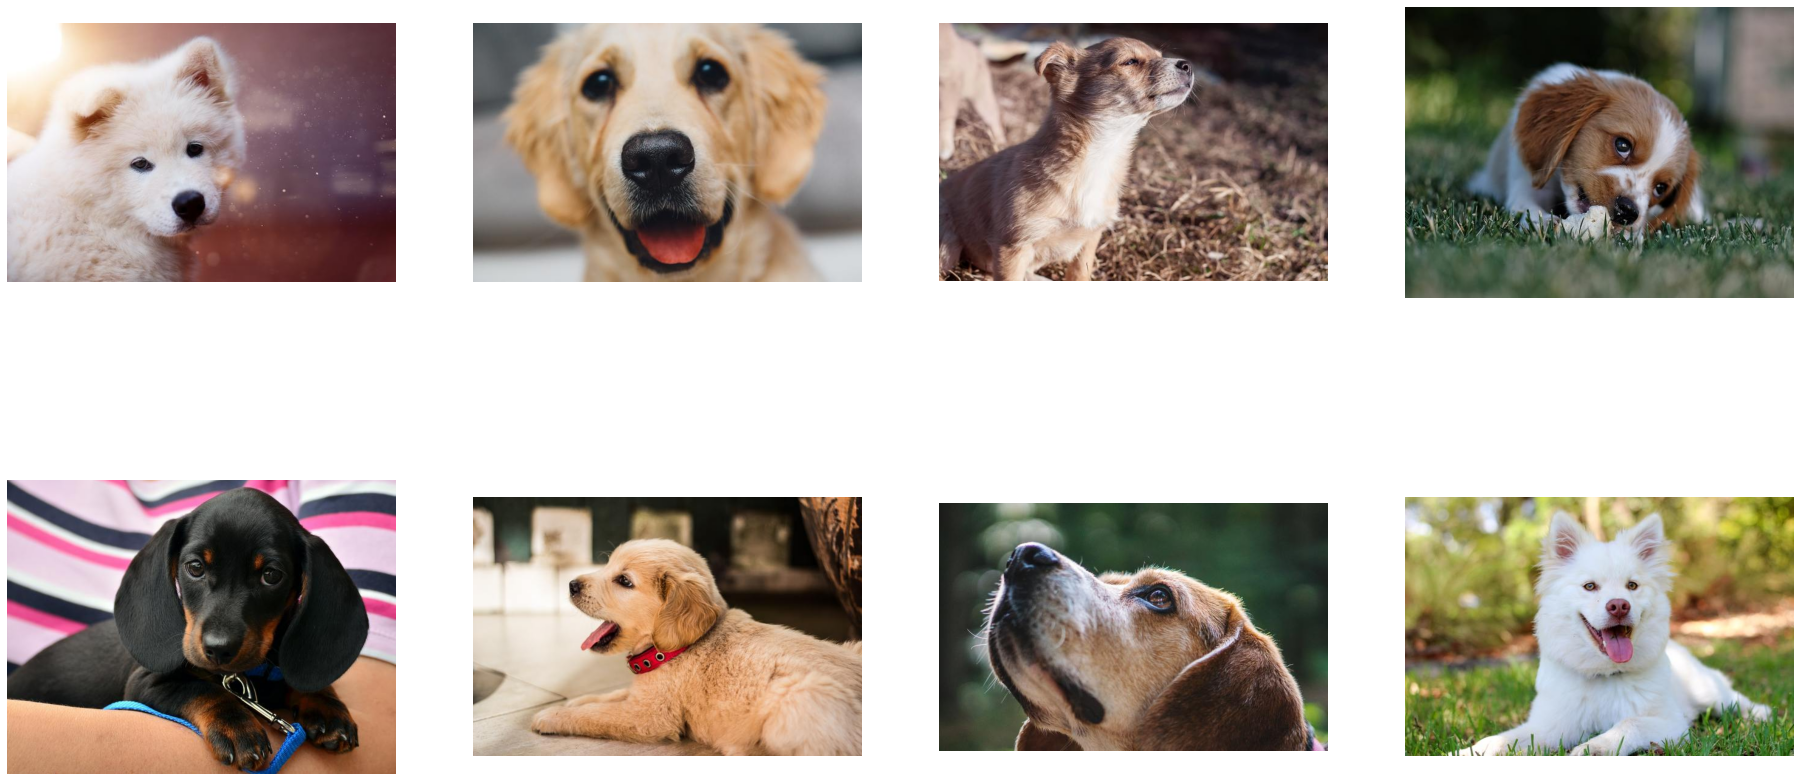

In [11]:
show_images(images)

In [5]:

image_dir = "data/images"
image_dir = "data/images"###   PIPELINE HELP   ###

#from nvidia.dali.pipeline import Pipeline
#help(Pipeline)
"""
Help on class Pipeline in module nvidia.dali.pipeline:

class Pipeline(builtins.object)
 |  Pipeline(batch_size=-1, num_threads=-1, device_id=-1, seed=-1, 
 |           exec_pipelined=True, prefetch_queue_depth=2, 
 |           exec_async=True, bytes_per_sample=0, set_affinity=False, 
 |           max_streams=-1, default_cuda_stream_priority=0, *, 
 |            enable_memory_stats=False)
 |  
 |  Pipeline class is the base of all DALI data pipelines. The pipeline
 |  encapsulates the data processing graph and the execution engine.
 |  
 |  Parameters
 |  ----------
 |  `batch_size` : int, optional, default = -1
 |      Batch size of the pipeline. Negative values for this parameter
 |      are invalid - the default value may only be used with
 |      serialized pipeline (the value stored in serialized pipeline
 |      is used instead).
 |
 |  `num_threads` : int, optional, default = -1
 |      Number of CPU threads used by the pipeline.
 |      Negative values for this parameter are invalid - the default
 |      value may only be used with serialized pipeline (the value
 |      stored in serialized pipeline is used instead).
 |
 |  `device_id` : int, optional, default = -1
 |      Id of GPU used by the pipeline.
 |      Negative values for this parameter are invalid - the default
 |      value may only be used with serialized pipeline (the value
 |      stored in serialized pipeline is used instead).
 |
 |  `seed` : int, optional, default = -1
 |      Seed used for random number generation. Leaving the default value
 |      for this parameter results in random seed.
 |
 |  `exec_pipelined` : bool, optional, default = True
 |      Whether to execute the pipeline in a way that enables
 |      overlapping CPU and GPU computation, typically resulting
 |      in faster execution speed, but larger memory consumption.
 |
 |  `prefetch_queue_depth` : int or {"cpu_size": int, "gpu_size": int}, optional, default = 2
 |      Depth of the executor pipeline. Deeper pipeline makes DALI
 |      more resistant to uneven execution time of each batch, but it
 |      also consumes more memory for internal buffers.
 |      Specifying a dict:
 |      ``{ "cpu_size": x, "gpu_size": y }``
 |      instead of an integer will cause the pipeline to use separated
 |      queues executor, with buffer queue size `x` for cpu stage
 |      and `y` for mixed and gpu stages. It is not supported when both `exec_async`
 |      and `exec_pipelined` are set to `False`.
 |      Executor will buffer cpu and gpu stages separatelly,
 |      and will fill the buffer queues when the first :meth:`run`
 |      is issued.
 |
 |  `exec_async` : bool, optional, default = True
 |      Whether to execute the pipeline asynchronously.
 |      This makes :meth:`run` method
 |      run asynchronously with respect to the calling Python thread.
 |      In order to synchronize with the pipeline one needs to call
 |      :meth:`outputs` method.
 |
 |  `bytes_per_sample` : int, optional, default = 0
 |      A hint for DALI for how much memory to use for its tensors.
 |
 |  `set_affinity` : bool, optional, default = False
 |      Whether to set CPU core affinity to the one closest to the
 |      GPU being used.
 |
 |  `max_streams` : int, optional, default = -1
 |      Limit the number of CUDA streams used by the executor.
 |      Value of -1 does not impose a limit.
 |      This parameter is currently unused (and behavior of
 |      unrestricted number of streams is assumed).
 |
 |  `default_cuda_stream_priority` : int, optional, default = 0
 |      CUDA stream priority used by DALI. See `cudaStreamCreateWithPriority` in CUDA documentation
 |
 |  `enable_memory_stats`: bool, optional, default = False
 |      If DALI should print operator output buffer statistics.
 |      Usefull for `bytes_per_sample_hint` operator parameter.
 |  
 |  Methods defined here:
 |  
 |  __enter__(self)
 |      Safely sets the pipeline as current.
 |      Current pipeline is required to call operators with side effects or without outputs.
 |      Examples of such operators are `PythonFunction` (potential side effects) or `DumpImage`
 |      (no output).
 |      
 |      Any dangling operator can be marked as having side effects if it's marked
 |      with `preserve=True`, which can be useful for debugging - otherwise operator which
 |      does not contribute to the pipeline output is removed from the graph.
 |      
 |      To manually set new (and restore previous) current pipeline, use :meth:`push_current`
 |      and :meth:`pop_current`, respectively.
 |  
 |  __exit__(self, exception_type, exception_value, traceback)
 |      Safely restores previous pipeline.
 |  
 |  __init__(self, batch_size=-1, num_threads=-1, device_id=-1, seed=-1, exec_pipelined=True, prefetch_queue_depth=2, exec_async=True, bytes_per_sample=0, set_affinity=False, max_streams=-1, default_cuda_stream_priority=0, *, enable_memory_stats=False)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  add_sink(self, edge)
 |      Allows to manual add of graph edges to the pipeline which are not connected to the output and all pruned
 |  
 |  build(self, define_graph=None)
 |      Build the pipeline.
 |      
 |      Pipeline needs to be built in order to run it standalone.
 |      Framework-specific plugins handle this step automatically.
 |      
 |      Parameters
 |      ----------
 |      define_graph : callable
 |          If specified, this function will be used instead of member :meth:`define_graph`.
 |          This parameter must not be set, if the pipeline outputs are specified with
 |          :meth:`set_outputs`.
 |  
 |  define_graph(self)
 |      This function is defined by the user to construct the
 |      graph of operations for their pipeline.
 |      
 |      It returns a list of outputs created by calling DALI Operators.
 |  
 |  deserialize_and_build(self, serialized_pipeline)
 |      Deserialize and build the pipeline given in serialized form.
 |      
 |      Parameters
 |      ----------
 |      serialized_pipeline : str
 |                            Serialized pipeline.
 |  
 |  empty(self)
 |      If there is any work scheduled in the pipeline but not yet consumed
 |  
 |  enable_api_check(self, enable)
 |      Allows to enable or disable API check in the runtime
 |  
 |  epoch_size(self, name=None)
 |      Epoch size of a pipeline.
 |      
 |      If the `name` parameter is `None`, returns a dictionary of pairs
 |      `(reader name, epoch size for that reader)`.
 |      If the `name` parameter is not `None`, returns epoch size for that
 |      reader.
 |      
 |      Parameters
 |      ----------
 |      name : str, optional, default = None
 |          The reader which should be used to obtain epoch size.
 |  
 |  executor_statistics(self)
 |      Returns provided pipeline executor statistics metadata as a dictionary.
 |      Each key in the dictionary is the operator name. To enable it use ``executor_statistics``
 |      
 |      Available metadata keys for each operator:
 |      
 |      ``real_memory_size``:     list of memory sizes that is used by each output of the operator;
 |                                index in the list corresponds to the output index
 |      
 |      ``max_real_memory_size``: list of maximum tensor size that is used by each output of the operator;
 |                                index in the list corresponds to the output index
 |      
 |      ``reserved_memory_size``: list of memory sizes that is reserved for each of the operator outputs
 |                                index in the list corresponds to the output index
 |      
 |      ``max_reserved_memory_size``: list of maximum memory sizes per tensor that is reserved for each of the operator outputs
 |                                index in the list corresponds to the output index
 |  
 |  feed_input(self, data_node, data, layout='', cuda_stream=None, use_copy_kernel=False)
 |      Pass a mutlidimensional array or DLPack (or a list thereof) to an output of ExternalSource.
 |      In the case of the GPU input, the data must be modified on the same stream as the one
 |      used by feed_input. See ``cuda_stream`` parameter for details.
 |      
 |      Parameters
 |      ----------
 |      data_node : :class:`DataNode` or str
 |          The name of the :class:`nvidia.dali.ops.ExternalSource` node or a :class:`DataNode`
 |          object returned by a call to that ExternalSource.
 |      
 |      data : an ndarray or DLPack or a list thereof
 |          The array(s) may be one of:
 |            * NumPy ndarray (CPU)
 |            * MXNet ndarray (CPU)
 |            * PyTorch tensor (CPU or GPU)
 |            * CuPy array (GPU)
 |            * objects implementing ``__cuda_array_interface__``
 |      
 |          The data to be used as the output of the ExternalSource referred to by `data_node`.
 |      
 |      layout : str
 |          The description of the data layout (or empty string, if not specified).
 |          It should be a string of the length that matches the dimensionality of the data, batch
 |          dimension excluded. For a batch of channel-first images, this should be "CHW", for
 |          channel-last video it's "FHWC" and so on.
 |      
 |      cuda_stream : optional, `cudaStream_t` or an object convertible to `cudaStream_t`, e.g. `cupy.cuda.Stream`, `torch.cuda.Stream`
 |          The CUDA stream, which is going to be used for copying data to GPU or from a GPU
 |          source. If not set, best effort will be taken to maintain correctness - i.e. if the data
 |          is provided as a tensor/array from a recognized library (CuPy, PyTorch), the library's
 |          current stream is used. This should work in typical scenarios, but advanced use cases
 |          (and code using unsupported libraries) may still need to supply the stream handle
 |          explicitly.
 |      
 |          Special values:
 |            *  0 - use default CUDA stream
 |            * -1 - use DALI's internal stream
 |      
 |          If internal stream is used, the call to ``feed_input`` will block until the copy to
 |          internal buffer is complete, since there's no way to synchronize with this stream to
 |          prevent overwriting the array with new data in another stream.
 |      
 |      use_copy_kernel : optional, `bool`
 |          If set to True, DALI will use a CUDA kernel to feed the data (only applicable when copying
 |          data to/from GPU memory) instead of cudaMemcpyAsync (default).
 |  
 |  iter_setup(self)
 |      This function can be overriden by user-defined
 |      pipeline to perform any needed setup for each iteration.
 |      For example, one can use this function to feed the input
 |      data from NumPy arrays.
 |  
 |  outputs(self)
 |      Returns the outputs of the pipeline and releases previous buffer.
 |      
 |      If the pipeline is executed asynchronously, this function blocks
 |      until the results become available. It rises StopIteration if data set
 |      reached its end - usually when iter_setup cannot produce any more data.
 |      
 |      :return:
 |          A list of `TensorList` objects for respective pipeline outputs
 |  
 |  reader_meta(self, name=None)
 |      Returns provided reader metadata as a dictionary. If no name is provided if provides
 |      a dictionary with data for all readers as {reader_name : meta}
 |      
 |      Available metadata keys:
 |      
 |      ``epoch_size``:        raw epoch size
 |      
 |      ``epoch_size_padded``: epoch size with the padding at the end to be divisible by the number of shards
 |      
 |      ``number_of_shards``:  number of shards
 |      
 |      ``shard_id``:          shard id of given reader
 |      
 |      ``pad_last_batch``:    if given reader should pad last batch
 |      
 |      ``stick_to_shard``:    if given reader should stick to its shard
 |      
 |      Parameters
 |      ----------
 |      name : str, optional, default = None
 |          The reader which should be used to obtain shards_number.
 |  
 |           default_cuda_stream_priority=0, *, enable_memory_stats=False)
 |  release_outputs(self)
 |      Release buffers returned by share_outputs calls.
 |      
 |      It helps in case when output call result is consumed (copied)
 |      and buffers can be marked as free before the next call to share_outputs. It provides
 |      the user with better control about when he wants to run the pipeline, when he wants
 |      to obtain the resulting buffers and when they can be returned to DALI pool when the
 |      results have been consumed.
 |      Needs to be used together with :meth:`schedule_run`
 |      and :meth:`share_outputs`
 |      Should not be mixed with :meth:`run` in the same pipeline
 |  
 |  reset(self)
 |      Resets pipeline iterator
 |      
 |      If pipeline iterator reached the end then reset its state to the beginning.
 |  
 |  run(self)
 |      Run the pipeline and return the result.
 |      
 |      If the pipeline was created with `exec_pipelined` option set to `True`,
 |      this function will also start prefetching the next iteration for
 |      faster execution.
 |      Should not be mixed with :meth:`schedule_run` in the same pipeline,
 |      :meth:`share_outputs` and
 |      :meth:`release_outputs`
 |      
 |      :return:
 |          A list of `TensorList` objects for respective pipeline outputs
 |  
 |  save_graph_to_dot_file(self, filename, show_tensors=False, show_ids=False, use_colors=False)
 |      Saves the pipeline graph to a file.
 |      
 |      Parameters
 |      ----------
 |      filename : str
 |                 Name of the file to which the graph is written.
 |      show_tensors : bool
 |                 Show the Tensor nodes in the graph (by default only Operator nodes are shown)
 |      show_ids : bool
 |                 Add the node id to the graph representation
 |      use_colors : bool
 |                 Whether use color to distinguish stages
 |  
 |  schedule_run(self)
 |      Run the pipeline without returning the resulting buffers.
 |      
 |      If the pipeline was created with `exec_pipelined` option set to `True`,
 |      this function will also start prefetching the next iteration for
 |      faster execution. It provides better control to the users about when they
 |      want to run the pipeline, when they want to obtain resulting buffers
 |      and return them to DALI buffer pool when the results have been consumed.
 |      Needs to be used together with :meth:`release_outputs`
 |      and :meth:`share_outputs`.
 |      Should not be mixed with :meth:`run` in the same pipeline
 |  
 |  serialize(self, define_graph=None, filename=None)
 |      Serialize the pipeline to a Protobuf string.
 |      
 |      Additionally, you can pass file name, so that serialized pipeline will be written there.
 |      The file contents will be overwritten
 |      
 |      Parameters
 |      ----------
 |      define_graph : allable
 |              If specified, this function will be used instead of member :meth:`define_graph`.
 |              This parameter must not be set, if the pipeline outputs are specified with
 |              :meth:`set_outputs`.
 |      filename : str
 |              File, from where serialized pipeline will be writeen.
 |      kwargs : dict
 |              Refer to Pipeline constructor for full list of arguments.
 |  
 |  set_outputs(self, *output_data_nodes)
 |      Set the outputs of the pipeline.
 |      
 |      Use of this function is an alternative to overriding `define_graph` in a derived class.
 |      
 |      Args
 |      ----
 |      `*output_data_nodes` : unpacked list of :class:`DataNode` objects
 |          The outputs of the pipeline
 |  
 |  share_outputs(self)
 |      Returns the outputs of the pipeline.
 |      
 |      Main difference to :meth:`outputs`
 |      is that share_outputs doesn't release returned buffers, release_outputs
 |      need to be called for that. If the pipeline is executed asynchronously,
 |      this function blocks until the results become available. It provides
 |      the user with better control about when he wants to run the pipeline, when he wants
 |      to obtain the resulting buffers and when they can be returned to DALI pool when the
 |      results have been consumed.
 |      Needs to be used together with :meth:`release_outputs`
 |      and :meth:`schedule_run`
 |      Should not be mixed with :meth:`run` in the same pipeline.
 |      
 |      :return:
 |          A list of `TensorList` objects for respective pipeline outputs
 |  
 |  ----------------------------------------------------------------------
 |  Class methods defined here:
 |  
 |  deserialize(serialized_pipeline=None, filename=None, **kwargs) from builtins.type
 |      Deserialize and build pipeline.
 |      
 |      Deserialize pipeline, previously serialized with ``serialize()`` method.
 |      
 |      Returned pipeline is already built.
 |      
 |      Alternatively, additional arguments can be passed, which will be used when instantiating
 |      the pipeline. Refer to Pipeline constructor for full list of arguments. By default,
 |      the pipeline will be instantiated with the arguments from serialized pipeline.
 |      
 |      Note, that ``serialized_pipeline`` and ``filename`` parameters are mutually exclusive
 |      
 |      Parameters
 |      ----------
 |      serialized_pipeline : str
 |                 Pipeline, serialized using ``serialize()`` method.
 |      filename : str
 |                 File, from which serialized pipeline will be read.
 |      kwargs : dict
 |                 Refer to Pipeline constructor for full list of arguments.
 |      
 |      Returns
 |      ----------
 |      Deserialized and built pipeline.
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  current()
 |  
 |  pop_current()
 |      Restores previous pipeline as current. Complementary to :meth:`push_current`.
 |  
 |  push_current(pipeline)
 |      Sets the pipeline as current and stores the previous current pipeline
 |      on stack. To restore previous pipeline as current, use :meth:`pop_current`.
 |      
 |      To make sure that the pipeline is properly restored in case of exception, use context
 |      manager (`with my_pipeline:`).
 |      
 |      Current pipeline is required to call operators with side effects or without outputs.
 |      Examples of such operators are `PythonFunction` (potential side effects) or `DumpImage`
 |      (no output).
 |      
 |      Any dangling operator can be marked as having side effects if it's marked
 |      with `preserve=True`, which can be useful for debugging - otherwise operator which
 |      does not contribute to the pipeline output is removed from the graph.
 |  
 |  ----------------------------------------------------------------------
 |  Readonly properties defined here:
 |  
 |  batch_size
 |      Batch size.
 |  
 |  device_id
 |      Id of the GPU used by the pipeline.
 |  
 |  exec_async
 |  
 |  exec_pipelined
 |  
 |  num_threads
 |      Number of CPU threads used by the pipeline.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)

"""
noprint = 1